In [59]:
import numpy as np
import tensorflow as tf
tf.random.set_seed(5)
from numpy.random import default_rng
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

# Hyperparams

In [60]:
np.set_printoptions(precision=2) 
num_pc = 1000 # number of PC
input_dim = 720 # BVC input size (720 bc RPLidar spits out a 720-point array)
timestep = 32 * 3
max_dist = 12 # max distance of LiDAR
tau_w = 10 # time constant for the window function
PI = tf.constant(np.pi) 
rng = default_rng() # random number generator
cmap = get_cmap('plasma')

C:\Users\bduke\AppData\Local\Temp\ipykernel_20148\985514278.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('plasma')


# BVC layer

In [61]:
class bvcLayer():
    def __init__(self, max_dist, input_dim, angular_tuning_width=90, n_hd=8, sigma_d=.5):
        '''
        Initializes the boundary vector cell (BVC) layer.

        Parameters:
        max_dist: Max distance that the BVCs respond to. Units depend on the context of the environment.
        input_dim: Size of input vector to the BVC layer (e.g., 720 for RPLidar).
        sigma_ang: Standard deviation for the Gaussian function modeling angular tuning of BVCs (in degrees).
        n_hd: Number of head direction cells.
        sigma_d: Standard deviation for the Gaussian function modeling distance tuning of BVCs.
        '''
        
        # Preferred distances for each BVC; determines how sensitive each BVC is to specific distances.
        # Shape: (1, num_distances), where num_distances = n_hd * (max_dist / (sigma_d/2))
        self.preferred_distances = np.tile(np.arange(0, max_dist, sigma_d/2), n_hd)[np.newaxis, :]  
        
        # Total number of BVC tuning points (number of preferred distances) = 384 ---> 8 head directions * 48 distances per head direction.
        self.num_distances = self.preferred_distances.size  
        
        # Indices for input vector, aligning BVCs with specific head directions.
        # Shape: (1, num_distances)
        self.input_indices = np.repeat(np.linspace(0, input_dim, n_hd, endpoint=False, dtype=int), max_dist/(sigma_d/2))[np.newaxis, :]
        
        # Preferred angles for each BVC (in radians).
        # Shape: (1, num_distances)
        self.preferred_angles = np.linspace(0, 2*np.pi, input_dim)[self.input_indices]  
        
        # Angular standard deviation for BVC tuning (converted to radians).
        self.sigma_ang  = tf.constant(np.deg2rad(angular_tuning_width), dtype=tf.float32)  
        
        # Placeholder for BVC output.
        self.bvc_out = None  

        # Distance standard deviation for BVC tuning.
        self.sigma_d = tf.constant(sigma_d, dtype=tf.float32)  
    
    def __call__(self, distances, angles):
        # How to use (in driver.py): self.pcn([self.boundaries, np.linspace(0, 2*np.pi, 720, False)], self.hdv, self.context, self.mode, np.any(self.collided))
        return tf.reduce_sum(self.compute_bvc_activation(distances, angles), 0)

    def compute_bvc_activation(self, distances, angles):
        # Gaussian function for distance tuning
        distance_gaussian = tf.exp(-(distances[self.input_indices] - self.preferred_distances)**2 / (2 * self.sigma_d**2)) / tf.sqrt(2 * PI * self.sigma_d**2)
        
        # Gaussian function for angular tuning
        angular_gaussian = tf.exp(-((angles[self.input_indices] - self.preferred_angles)**2) / (2 * self.sigma_ang**2)) / tf.sqrt(2 * PI * self.sigma_ang**2)
        
        # Return the product of distance and angular Gaussian functions
        return distance_gaussian * angular_gaussian


# Place cell layer

In [62]:
class PlaceCellLayer(): # Called continuously during explore loop in driver.py
    def __init__(self, num_pc, input_dim, timestep, max_dist, n_hd):
        '''
        Initializes the Place Cell Layer.

        Parameters:
        num_pc: Number of place cells in the layer.
        input_dim: Dimension of the input vector to the layer (e.g., 720 for RPLidar).
        timestep: Time step for simulation or learning updates.
        max_dist: Maximum distance that the boundary vector cells (BVCs) respond to.
        n_hd: Number of head direction cells.
        '''
        
        # Number of place cells
        self.num_pc = num_pc
        
        # Initialize the Boundary Vector Cell (BVC) layer
        self.bvcLayer = bvcLayer(max_dist, input_dim)
        
        # Number of BVCs (Boundary Vector Cells)
        self.num_bvc = self.bvcLayer.num_distances
        
        # Recurrent weight matrix for place-to-place cell connections, considering head direction
        # Shape: (n_hd, num_pc, num_pc)
        self.w_rec_place_to_place = tf.Variable(np.zeros((n_hd, num_pc, num_pc)), dtype=tf.float32)
        
        # Input weight matrix connecting place cells to BVCs
        # Shape: (num_pc, num_bvc)
        self.w_in = tf.Variable(rng.binomial(1, .2, (num_pc, self.num_bvc)), dtype=tf.float32)
        
        # Recurrent weight matrix for head direction and place cell interactions
        # Shape: (n_hd, num_pc, num_pc)
        self.w_rec_hd_place = tf.zeros(shape=(n_hd, num_pc, num_pc), dtype=tf.float32)
        
        # Initial activation values for place cells
        # Shape: (num_pc,)
        self.place_cell_activations = tf.zeros(num_pc, dtype=tf.float32)
        
        # Time constant for updating place cell activations
        self.tau = timestep / 1000
        
        # Initial activations for boundary vector cells (BVCs)
        # Shape: (num_bvc,)
        self.bvc_activations = tf.zeros(self.num_bvc, dtype=tf.float32)
        
        # Learning rate for the place cell update rule
        self.alpha = 0.5
        
        # Previous place cell activations
        # Shape: (num_pc,)
        self.prev_place_cell_activations = tf.zeros(num_pc, dtype=tf.float32)
        
        # Initial weights for the input connections from BVCs to place cells
        self.initial_w_in = tf.Variable(self.w_in)
        
        # Temporary variable for the current activation update step
        # Shape: (num_pc,)
        self.activation_update = tf.zeros_like(self.place_cell_activations, dtype=tf.float32)
        
        # Placeholder for recurrent connections
        self.recurrent_input = 0
        
        # Head direction modulation (if applicable, otherwise remains None)
        self.head_direction_modulation = None
        
        # Boundary cell activation values (if any boundary cells are used)
        self.boundary_cell_activations = tf.zeros((n_hd, num_pc))
        
        # Trace of place cell activations for eligibility tracking
        self.place_cell_trace = tf.zeros_like(self.place_cell_activations)
        
        # Trace of head direction cells for eligibility tracking
        self.hd_cell_trace = tf.zeros((n_hd, 1, 1), tf.float64)

    def __call__(self, input_data, head_direction_vector, mode="learn", collided=False):
        '''
        Computes the activation of place cells based on the input from boundary vector cells (BVCs) and head direction vectors (HDV).

        Parameters:
        input_data: Input to the BVC layer. 
                    - input_data[0]: Array of distances (e.g., from RPLidar).
                    - input_data[1]: Array of angles corresponding to those distances.
        head_direction_vector: Head direction vector (HDV) indicating the direction the agent is facing.
        mode: Operation mode, typically "learn" or "test".
        collided: Boolean indicating if the agent has collided with an obstacle.
        '''

        # Store the previous place cell activations
        # Shape: (num_place_cells,)
        self.prev_place_cell_activations = tf.identity(self.place_cell_activations)

        # Compute BVC activations based on the input distances and angles
        # input_data[0] = distances array from RPLidar, input_data[1] = angles 
        # Shape: (num_bvc,)
        self.bvc_activations = self.bvcLayer(input_data[0], input_data[1])
        
        # Compute the input to place cells by taking the dot product of the input weights and BVC activations
        # Shape: (num_place_cells,)
        place_cell_input = tf.tensordot(self.w_in, self.bvc_activations, 1) - 0.3 * tf.reduce_sum(self.bvc_activations)
        
        # Update the activation variable `activation_update` with the new input, applying a scaling factor and considering previous activations
        # Shape: (num_place_cells,)
        self.activation_update += 0.1 * (place_cell_input - self.activation_update - self.alpha * tf.reduce_sum(tf.cast(self.place_cell_activations, tf.float32)))
        
        # Apply ReLU followed by tanh to compute the new place cell activations
        # Shape: (num_place_cells,)
        self.place_cell_activations = tf.tanh(tf.nn.relu(self.activation_update))

        # Update the eligibility trace and weights if in "dmtp" mode and no collision
        if np.any(self.place_cell_activations) and mode == "dmtp" and not collided:
            
            if self.place_cell_trace is None:
                self.place_cell_trace = tf.zeros_like(self.place_cell_activations)

            # Update the eligibility trace for place cells and head direction cells
            # Shape: (num_place_cells,)
            self.place_cell_trace += self.tau / 3 * (self.place_cell_activations - self.place_cell_trace)
            
            # Shape: (num_hd, 1, 1)
            self.hd_cell_trace += self.tau / 3 * (np.nan_to_num(head_direction_vector)[:, np.newaxis, np.newaxis] - self.hd_cell_trace)
            
            # Update recurrent weights for place cell interactions modulated by head direction
            # Shape: (n_hd, num_place_cells, num_place_cells)
            self.recurrent_weights += tf.cast(np.nan_to_num(head_direction_vector)[:, np.newaxis, np.newaxis], tf.float32) * (
                tf.tensordot(self.place_cell_activations[:, np.newaxis], self.place_cell_trace[np.newaxis, :], 1) -
                tf.tensordot(self.place_cell_trace[:, np.newaxis], self.place_cell_activations[np.newaxis, :], 1)
            )

        # If the mode is not "learning", update the input weights based on the current activations and BVC activations
        if np.any(self.place_cell_activations) and not (mode == 'learning'):
            # Update input weights based on the place cell activations and BVC activations
            # Shape: (num_place_cells, num_bvc)
            weight_update = self.tau * (
                self.place_cell_activations[:, np.newaxis] * (self.bvc_activations[np.newaxis, :] - 
                1 / np.sqrt(0.5) * self.place_cell_activations[:, np.newaxis] * self.w_in)
            )
            self.w_in.assign_add(weight_update)

    def pcn_exploit(self, direction, num_steps=1):
        '''
        Exploits the current state to generate place cell activations based on the recurrent weights.

        Parameters:
        direction: The direction in which to exploit the recurrent weights. 
        num_steps: Number of exploitation steps to perform.
        '''

        # Copy the current place cell activations
        # Shape: (num_place_cells,)
        place_cell_activations = tf.identity(self.place_cell_activations)
        
        # Check for collision (optional, currently commented out)
        # if tf.tensordot(self.boundary_cell_weights, self.place_cell_activations, 1)[direction] >= 0.5:
        #     return tf.zeros_like(place_cell_activations)

        # Iterate to update the place cell activations
        for step in range(num_steps):
            previous_activations = tf.identity(place_cell_activations)
            
            # Compute new activations based on recurrent weights and previous activations
            # Shape: (num_place_cells,)
            place_cell_activations = tf.tanh(
                tf.nn.relu(
                    tf.tensordot(tf.cast(self.recurrent_weights[direction], tf.float32), previous_activations, 1) 
                    - previous_activations
                )
            )

        # Visualization
        # fig = plot.figure(1)
        # ax = fig.add_subplot(3, 3, plot_location[direction])
        # current_estimate = np.dot(hmap_z, place_cell_activations)
        # try:
        #     ax.tricontourf(hmap_x, hmap_y, current_estimate, cmap=cmap)
        #     ax.set_aspect('equal')
        #     ax.set_ylim(5, -5)
        #     ax.set_title("Norm {0:.2f}".format(tf.linalg.norm(place_cell_activations, 1)))
        # except:
        #     pass
        
        # Return the updated place cell activations
        return place_cell_activations
    
    def __getitem__(self, index):
        '''
        Retrieves the place cell activation at the specified index.
        Example: 
            activation = place_cell_layer[5] = activation of the place cell at index 5

        Parameters:
        index: The index of the place cell activation to retrieve.

        Returns:
        The activation value of the place cell at the specified index.
        '''
        return self.place_cell_activations[index]

# Reward cell layer

In [63]:
class RewardCellLayer:

    def __init__(self, num_reward_cells, input_dim, num_replay):
        '''
        Initializes the Reward Cell Layer.

        Parameters:
        num_reward_cells: Number of reward cells in the layer.
        input_dim: Dimension of the input vector to the layer.
        num_replay: Number of replay iterations for the reward learning process.
        '''
        # Number of reward cells
        self.num_reward_cells = num_reward_cells
        
        # Input weight matrix connecting reward cells to input data
        # Shape: (num_reward_cells, input_dim)
        self.w_in = tf.Variable(np.zeros((num_reward_cells, input_dim)), dtype=tf.float32)
        
        # Activation values for reward cells
        # Shape: (num_reward_cells, 1)
        self.reward_cell_activations = tf.zeros((num_reward_cells, 1), dtype=tf.float32)
        
        # Number of replay iterations
        self.num_replay = num_replay
        
        # Effective input weight matrix, used for updating during visits
        self.w_in_effective = tf.identity(self.w_in)

    def __call__(self, input_data, visit=False, context_index=1):
        '''
        Computes the activations of reward cells based on input data.

        Parameters:
        input_data: The input data for the reward cells.
        visit: Boolean flag indicating if the cell is being visited.
        context_index: Context index for selecting specific input weights.
        '''
        self.reward_cell_activations = tf.tensordot(self.w_in_effective, input_data, 1) / tf.linalg.norm(input_data, 1)

        if visit:
            updated_weights = self.w_in_effective[context_index] - 0.2 * input_data * self.w_in_effective[context_index]
            self.w_in_effective = tf.tensor_scatter_nd_update(self.w_in_effective, [[context_index]], [updated_weights])

    def new_reward(self, place_cell_layer, context_index=0, target=None):
        '''
        Updates the input weights based on place cell network activations through replay.

        Parameters:
        place_cell_layer: The place cell network whose activations influence the reward cell weights.
        context_index: Context index for selecting specific input weights.
        target: Target vector for unlearning, if provided.
        '''
        place_cell_layer = deepcopy(place_cell_layer)
        delta_weights = tf.zeros_like(self.w_in)

        for t in range(10):
            # Update weights if a target is specified for unlearning
            if target is not None:
                update_value = tf.maximum(0, self.w_in_effective[context_index] - 0.6 * place_cell_layer.place_cell_activations)
                self.w_in_effective = tf.tensor_scatter_nd_update(self.w_in_effective, [[context_index]], [update_value])
                print("Unlearned weights minimum:", tf.reduce_min(self.w_in_effective))
                return

            # Accumulate weight changes over time, modulated by the replay steps
            delta_weights = tf.tensor_scatter_nd_add(delta_weights, [[context_index]], [
                tf.math.exp(-t / 6) * tf.linalg.normalize(place_cell_layer.place_cell_activations, np.inf)[0]
            ])

            # Update the place cell network activations
            previous_activations = tf.identity(place_cell_layer.place_cell_activations)
            new_activations = tf.nn.relu(
                tf.tensordot(tf.cast(tf.reduce_max(place_cell_layer.w_rec_place_to_place, 0), tf.float32), previous_activations, 1) + previous_activations
            )
            place_cell_layer.place_cell_activations = tf.tanh(new_activations)

        # Normalize and update input weights
        self.w_in.assign_add(tf.linalg.normalize(delta_weights, np.inf)[0])
        self.w_in_effective = tf.identity(self.w_in)

# Test

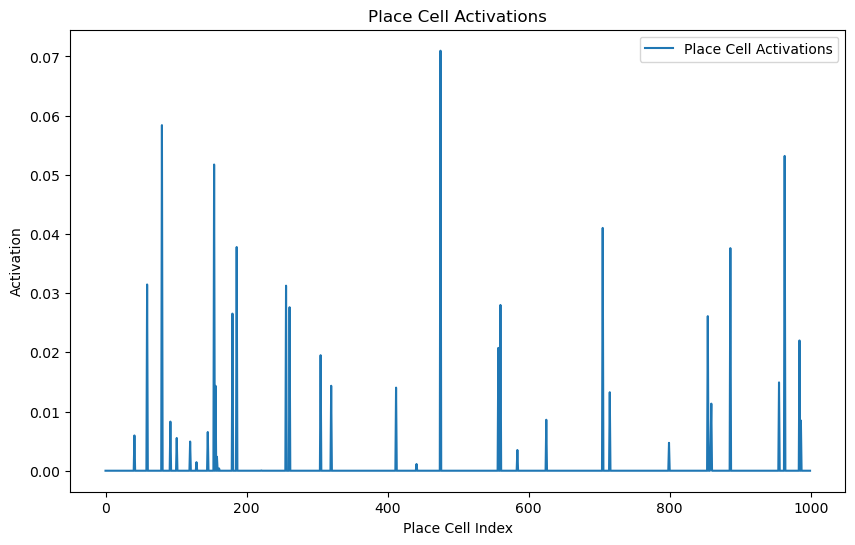

In [64]:
# Assume PlaceCellLayer and bvcLayer classes are already defined as per your provided code

# Initialize the model
place_cell_layer = PlaceCellLayer(num_pc=1000, input_dim=720, timestep=32*3, max_dist=12, n_hd=8)

# Simulate some input data
# Simulated distances (e.g., from RPLidar)
simulated_distances = np.linspace(0, 12, 720)  # 720-point array from 0 to 12 meters

# Simulated angles (0 to 2*pi radians)
simulated_angles = np.linspace(0, 2 * np.pi, 720)

# Simulated head direction vector
simulated_hdv = np.ones(8)  # Assume uniform head direction vector for simplicity

# Run the model
place_cell_layer([simulated_distances, simulated_angles], simulated_hdv)

# Plot the activations of the place cells
plt.figure(figsize=(10, 6))
plt.plot(place_cell_layer.place_cell_activations.numpy(), label="Place Cell Activations")
plt.title("Place Cell Activations")
plt.xlabel("Place Cell Index")
plt.ylabel("Activation")
plt.legend()
plt.show()